In [1]:
#  import main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import shap

# define variables
immo_vis_dir = "../../data/immo_vis/"
parquet_extension = ".parquet"
metropole_appartement_file = "ventes-metropole-appartement" + parquet_extension
metropole_appartement_file_cleaned = metropole_appartement_file + "_step1_clean_" + parquet_extension

acp_appartement_file = "df_ACP_IRIS_immo_Processed"  + parquet_extension

#  Set plot options
LargePlotActive = False
MediumPlotActive = False
SmallPlotActive = False
HeatMapDisplay = False

lgbRegressionON = False
XGBRegressorON = False
GridSearchXGBRegressor = False
GridSearchDecisionTree = False
XGBRegressorOpimizedON = True
DecisionTreeDisplay = False
ShapDisplay = True

DropRegDep = True
AddACP = True

# # functions

In [2]:
# functions  
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import time

def print_numerical_isna(df) :
    columns = df.select_dtypes(include='number').columns.tolist()
    print (df[columns].isna().sum())

def print_categorial_isna(df) :
    columns = df.select_dtypes(include='category').columns.tolist()
    print (df[columns].isna().sum())     

def load_appartement_file (filename) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / filename
    return pd.read_parquet(final_path.as_posix())

def save_appartement_file (df, filename) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / filename
    df.to_parquet(path=final_path.as_posix(),index=True)

def get_numerical_column_names (df) :
    return [ column for column  in df.columns if df[column].dtype not in ["object","category"]]

def apply_scale_processing(operator,X_train,X_test):
    #Operator could be scaler or encode
    op=operator
    op.fit(X_train)
    X_train_treated=pd.DataFrame(op.transform(X_train),columns=X_train.columns)
    X_test_treated=pd.DataFrame(op.transform(X_test),columns=X_train.columns)
    return X_train_treated,X_test_treated

def apply_preprocessing  (df, drop_region = True) :
    y_tmp =df['prix_m2_vente']
    columns = ['prix_m2_vente','prix_bien','date',"expo_double","CODE_IRIS"]
    if drop_region :
        columns.append("DEP")
        columns.append("REG")
        columns.append("surface")


    X_tmp =df.drop(columns=columns)
    return X_tmp,y_tmp

def create_train_test_data (X ,y) :
    from sklearn.model_selection import train_test_split
    #  build the train and test data
    print (X.shape)
    return train_test_split(X,y,test_size=0.2,random_state=42)

def create_train_test_data_subset (X ,y,subset_size = 1.0) :
    from sklearn.model_selection import train_test_split
    #  build the train and test data
    print (X.shape)
    return train_test_split(X,y,test_size=0.2,train_size=subset_size, random_state=42)

# # decode file and display infos

In [3]:
# import appartement file

df_processed= load_appartement_file(metropole_appartement_file_cleaned)
nb_rows= df_processed.shape[0]
nb_cols= df_processed.shape[1]

In [4]:
#  print main infos on appartmeent file

print ( f" {metropole_appartement_file_cleaned} rows {nb_rows} columns {nb_cols}")
print (df_processed.info())



 ventes-metropole-appartement.parquet_step1_clean_.parquet rows 2077476 columns 46
<class 'pandas.core.frame.DataFrame'>
Index: 2077476 entries, immo-facile-57743459 to 134327817
Data columns (total 46 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   etage                    int64         
 1   surface                  int64         
 2   nb_pieces                int64         
 3   prix_bien                int64         
 4   balcon                   int64         
 5   eau                      int64         
 6   bain                     int64         
 7   annonce_exclusive        int64         
 8   nb_etages                float64       
 9   places_parking           float64       
 10  cave                     int64         
 11  annee_construction       float64       
 12  nb_toilettes             int64         
 13  nb_terraces              float64       
 14  videophone               int64         
 15  porte_digicode    

In [5]:
ACPS = {"PC1": "1 Urbain dense",
        "PC2" : "2 Péri urbain résidentiel",
        "PC3" : "3 Professions Supérieures",
        "PC4" : "4 Seniors balnéaires",
        "PC5" : "5 territoires en croissance",
        "PC6" : "6 Délinquance centre ville",
        "PC7" : "7 trafic de stupéfiants",
        "PC8" : "PC8",
        "PC9" : "PC9",
        "PC10" : "PC10",
        "PC11":  "PC11",
        "PC12" : "PC12",
        "PC13" : "PC13",
        "PC14" : "14 Villages anciens, commerces",
        "PC15" : "PC15",
        "PC16" : "PC16",
        "PC17" : "PC17",
        "PC18" : "PC18",
        "PC19" : "PC19",
        "PC20" : "PC20",
        "CODE_IRIS" : "CODE_IRIS"
       }

# Decode ACP file 

In [6]:
if AddACP :
    df_iris = load_appartement_file(acp_appartement_file)
    nb_rows= df_iris.shape[0]
    nb_cols= df_iris.shape[1]

    print ( f" {acp_appartement_file} rows {nb_rows} columns {nb_cols}")

    df_iris = df_iris.rename(ACPS,axis=1)

    print(" df_iris nan values",df_iris.isna().sum().sum())


    #  chop data

    print (df_iris.info())

 df_ACP_IRIS_immo_Processed.parquet rows 46806 columns 21
 df_iris nan values 0
<class 'pandas.core.frame.DataFrame'>
Index: 46806 entries, 0 to 46805
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CODE_IRIS                       46806 non-null  int64  
 1   1 Urbain dense                  46806 non-null  float64
 2   2 Péri urbain résidentiel       46806 non-null  float64
 3   3 Professions Supérieures       46806 non-null  float64
 4   4 Seniors balnéaires            46806 non-null  float64
 5   5 territoires en croissance     46806 non-null  float64
 6   6 Délinquance centre ville      46806 non-null  float64
 7   7 trafic de stupéfiants         46806 non-null  float64
 8   PC8                             46806 non-null  float64
 9   PC9                             46806 non-null  float64
 10  PC10                            46806 non-null  float64
 11  PC11              

# select the number of ACP to keep

In [7]:
if AddACP :
    keep_acp = 15
    acp_filter = list(range(0, keep_acp + 1))
    df_iris = df_iris.iloc[:,acp_filter]
    print (df_iris.info())
    display(df_iris)

<class 'pandas.core.frame.DataFrame'>
Index: 46806 entries, 0 to 46805
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CODE_IRIS                       46806 non-null  int64  
 1   1 Urbain dense                  46806 non-null  float64
 2   2 Péri urbain résidentiel       46806 non-null  float64
 3   3 Professions Supérieures       46806 non-null  float64
 4   4 Seniors balnéaires            46806 non-null  float64
 5   5 territoires en croissance     46806 non-null  float64
 6   6 Délinquance centre ville      46806 non-null  float64
 7   7 trafic de stupéfiants         46806 non-null  float64
 8   PC8                             46806 non-null  float64
 9   PC9                             46806 non-null  float64
 10  PC10                            46806 non-null  float64
 11  PC11                            46806 non-null  float64
 12  PC12                            46806

,CODE_IRIS,1 Urbain dense,2 Péri urbain résidentiel,3 Professions Supérieures,4 Seniors balnéaires,5 territoires en croissance,6 Délinquance centre ville,7 trafic de stupéfiants,PC8,PC9,PC10,PC11,PC12,PC13,"14 Villages anciens, commerces",PC15
0,10010000,-2.36,2.29,-0.27,0.52,-1.03,-0.27,0.03,0.14,-0.08,0.27,-0.61,-0.43,0.23,-0.36,1.04
1,10020000,-3.90,1.27,2.35,-0.27,0.56,0.14,0.57,1.23,1.24,-0.55,1.08,-0.61,0.47,-1.22,-0.56
2,10040101,6.94,0.55,-0.85,-0.53,1.25,0.61,-2.41,-1.14,-0.77,1.41,-0.92,-1.17,-0.72,0.75,0.50
3,10040102,6.95,-1.30,-3.22,-0.48,0.95,0.45,-0.73,-1.56,1.22,0.15,-1.03,-1.21,-0.06,-0.33,0.84
4,10040201,6.34,-0.10,-2.81,0.64,2.00,0.87,-1.52,-0.80,1.09,-0.22,-1.27,-1.67,-0.71,-0.31,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46801,956800112,8.56,-3.51,-4.11,-3.73,-1.08,-2.18,3.42,0.77,0.38,-0.13,0.90,1.08,1.23,-0.16,0.50
46802,956800113,8.99,-0.71,-4.90,-5.23,2.63,-1.20,2.73,-0.97,1.11,-1.16,1.65,0.31,1.21,-0.76,-0.02
46803,956800114,9.57,-4.39,-4.55,-4.01,-1.36,-2.74,4.11,0.91,1.06,-0.73,0.28,0.88,0.53,-0.20,0.31
46804,956820000,-0.89,2.98,0.71,-2.13,-0.34,-0.26,-0.35,2.11,-0.38,-0.62,-1.12,-0.58,0.05,0.31,-0.78


# Merge Data and ACP

In [8]:
if AddACP :
    df=df_processed.merge(df_iris,how='left',on='CODE_IRIS')
    df.info(show_counts=True)
    df = df.fillna(0)
    print("df merged isna() ", df.isna().sum().sum())
    print(df.shape)
    display(df)
else :
    df=df_processed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077476 entries, 0 to 2077475
Data columns (total 61 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   etage                           2077476 non-null  int64         
 1   surface                         2077476 non-null  int64         
 2   nb_pieces                       2077476 non-null  int64         
 3   prix_bien                       2077476 non-null  int64         
 4   balcon                          2077476 non-null  int64         
 5   eau                             2077476 non-null  int64         
 6   bain                            2077476 non-null  int64         
 7   annonce_exclusive               2077476 non-null  int64         
 8   nb_etages                       2077476 non-null  float64       
 9   places_parking                  2077476 non-null  float64       
 10  cave                            2077476 no

,etage,surface,nb_pieces,prix_bien,balcon,eau,bain,annonce_exclusive,nb_etages,places_parking,...,6 Délinquance centre ville,7 trafic de stupéfiants,PC8,PC9,PC10,PC11,PC12,PC13,"14 Villages anciens, commerces",PC15
0,0,65,2,136000,0,0,0,1,4.0,3.0,...,1.37,-0.04,0.03,1.43,0.64,-0.42,0.58,0.38,-0.29,0.02
1,1,72,3,369000,0,0,1,0,3.0,2.0,...,0.20,1.27,-0.32,2.05,-0.12,-0.64,-1.53,-0.38,-0.78,0.66
2,2,128,5,440000,1,1,1,0,3.0,1.0,...,0.20,1.27,-0.32,2.05,-0.12,-0.64,-1.53,-0.38,-0.78,0.66
3,0,76,4,170000,0,1,0,0,4.0,2.0,...,0.84,-0.38,-1.52,1.37,0.22,-0.13,-0.27,-0.31,-0.13,0.10
4,0,84,3,449000,0,0,0,1,4.0,1.0,...,-1.68,2.92,-1.12,0.04,0.92,0.24,-2.29,-0.61,0.18,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077471,1,59,2,202419,0,1,0,2,4.0,0.0,...,1.62,-3.34,0.06,-0.37,0.23,0.33,-0.03,0.14,0.56,0.58
2077472,2,36,2,110000,0,1,0,2,4.0,0.0,...,1.62,-3.34,0.06,-0.37,0.23,0.33,-0.03,0.14,0.56,0.58
2077473,1,97,4,169500,0,0,1,2,4.0,0.0,...,1.54,-0.92,1.60,1.23,-0.49,-0.00,-0.03,-0.70,-0.09,0.25
2077474,1,132,5,315000,0,0,0,2,4.0,0.0,...,1.54,-0.92,1.60,1.23,-0.49,-0.00,-0.03,-0.70,-0.09,0.25


# 1st Model Encoding

In [9]:
# check dtypes
display(df.dtypes)
print("porte_digicode",df.porte_digicode.unique())
print("ascenceur",df.ascenseur.unique())
print("cave",df.ascenseur.unique())

etage                               int64
surface                             int64
nb_pieces                           int64
prix_bien                           int64
balcon                              int64
                                   ...   
PC11                              float64
PC12                              float64
PC13                              float64
14 Villages anciens, commerces    float64
PC15                              float64
Length: 61, dtype: object

porte_digicode [0 1]
ascenceur [0 1]
cave [0 1]


# # Preprocessing

In [10]:
# set target and data
print (df.columns)
X,y = apply_preprocessing(df,drop_region=DropRegDep)
print (df.columns)


Index(['etage', 'surface', 'nb_pieces', 'prix_bien', 'balcon', 'eau', 'bain',
       'annonce_exclusive', 'nb_etages', 'places_parking', 'cave',
       'annee_construction', 'nb_toilettes', 'nb_terraces', 'videophone',
       'porte_digicode', 'ascenseur', 'nb_logements_copro', 'logement_neuf',
       'date', 'CODE_IRIS', 'REG', 'DEP', 'prix_m2_vente', 'charges_copro_m2',
       'dpeL_num', 'ges_class_num', 'chauf_energy_gaz', 'chauf_energy_elec',
       'chauf_energy_bois', 'chauf_energy_fioul', 'chauf_sys_climatisation',
       'chauf_sys_pompe_chaleur', 'chauf_sys_convecteur',
       'chauf_sys_radiateur', 'chauf_sys_chaudiere', 'chauf_sys_sol',
       'chauf_sys_poele_bois', 'chauf_mode_individuel', 'chauf_mode_collectif',
       'chauf_mode_central', 'expo_has_nord', 'expo_has_sud', 'expo_has_est',
       'expo_has_ouest', 'expo_double', '1 Urbain dense',
       '2 Péri urbain résidentiel', '3 Professions Supérieures',
       '4 Seniors balnéaires', '5 territoires en croissance',


#  # create train test dataset

In [11]:
#  train test split
from sklearn.model_selection import train_test_split
#  build the train and test data

X_train, X_test, y_train, y_test = create_train_test_data(X,y)

(2077476, 53)


In [12]:
# apply min max scaler
from sklearn.preprocessing import MinMaxScaler

if lgbRegressionON :
    X_train_scaled,X_test_scaled=apply_scale_processing(MinMaxScaler(),X_train,X_test)



# # train ans predict models

In [13]:
def fit_train_models (models,X_train, y_train,X_test,y_test) :
    results = []
    for name, model in models.items():
        print(f"Entraînement de {name}...")
        
        # Mesurer le temps d'entraînement
        start_time = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_time
        
        # Mesurer le temps de prédiction
        start_time = time.time()
        y_pred = model.predict(X_test)
        predict_time = time.time() - start_time
        
        # Calculer les métriques
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'RMSE': rmse,
            'R²': r2,
            'Fit_Time': f"{fit_time:.4f}s",
            'Predict_Time': f"{predict_time:.4f}s",
            'Total_Time': f"{fit_time + predict_time:.4f}s"
        })

    # Afficher les résultats
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('RMSE')


    return results_df


In [14]:

import lightgbm as lgb
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression, Ridge
from sklearn.svm import SVR, LinearSVR

# Liste des modèles à tester
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'ElasticNetCV': ElasticNetCV(),
    'LinearSVR': LinearSVR(),
    # 'SVR': SVR(),
    # 'Random Forest': RandomForestRegressor(n_estimators=20, random_state=42),
    'lgb' : lgb.LGBMRegressor(
                            objective='regression',
                            metric='rmse',
                            num_leaves=31,
                            learning_rate=0.05,
                            force_row_wise=True,
                            # feature_fraction=0.9,
                        )
}

# Tester chaque modèle avec mesure du temps
if lgbRegressionON :
    results = fit_train_models(models,X_train_scaled,y_train,X_test_scaled,y_test)

    # Afficher les résultats
    print(results)


In [ ]:



# Liste des modèles à tester
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


models = {
    # 'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'XGBRegressor' : XGBRegressor(n_estimators=100, random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=10, random_state=42),
#     'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=20, random_state=42),
#     'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
}

# Tester chaque modèle avec mesure du temps

if XGBRegressorON :
    results = fit_train_models(models,X_train,y_train,X_test,y_test)

    # Afficher les résultats
    print(results)


#  # improve hyper parameters 

In [16]:
from enum import Enum
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.metrics import  mean_absolute_error, mean_squared_error

class SearchModel (Enum) :
    GRID=1,
    BAYES = 2

def optimize_hyperparameters_grid_search (search_model, estimator_name, estimator, param_grid,X_train, y_train,X_test,y_test,display_curve= False) :
# Initialize XGBRegressor

    # Setup GridSearchCV
    print (f" Search Moel {search_model}")
    if search_model == SearchModel.GRID : 
        grid_search = GridSearchCV( # pyright: ignore[reportUndefinedVariable]
            estimator=estimator,
            param_grid=param_grid,
            cv=5,  # 5-fold cross-validation
            scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
            verbose=2,
            n_jobs=-1,
            return_train_score=True
    ) 
    elif search_model == SearchModel.BAYES:
           grid_search = BayesSearchCV(
            estimator=estimator,
            search_spaces=param_grid,
            cv=5,  # 5-fold cross-validation
            scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error'
            verbose=2,
            n_jobs=-1,
            return_train_score=True )

    # Fit the grid search
    print(f"Starting GridSearchCV {estimator_name} fit ...")
    grid_search.fit(X_train, y_train)
    print(f"Ending GridSearchCV {estimator_name} fit ...")

    # Best parameters and score
    print(f"Best estimator : {estimator_name} {grid_search.best_estimator_}")
    print(f"Best paramters : {estimator_name} {grid_search.best_params_}")
    print(f"Best score : {estimator_name} {grid_search.best_params_}")

    print("\n" + "="*60)
    print("BEST PARAMETERS:")
    print("="*60)
    for param, value in grid_search.best_params_.items():
        print(f"{param:20s}: {value}")

    print(f"\nBest CV Score (neg MSE): {grid_search.best_score_:.4f}")
    print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

    # Train best model on full training set and evaluate
    print(f"Starting GridSearchCV {estimator_name} predict ...")
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n" + "="*60)
    print("TEST SET PERFORMANCE:")
    print("="*60)
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

    # Display top 10 parameter combinations
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df['mean_rmse'] = np.sqrt(-results_df['mean_test_score'])
    top_10 = results_df.nsmallest(10, 'mean_rmse')[['params', 'mean_rmse', 'std_test_score']]
    print("\n" + "="*60)
    print("TOP 10 PARAMETER COMBINATIONS:")
    print("="*60)
    print(top_10.to_string(index=False))

    # Feature importance plot
    if display_curve :
        feature_importance = best_model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(feature_importance)), feature_importance)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Index')
        plt.title('Feature Importance from Best XGBRegressor Model')
        plt.tight_layout()

        plt.show()
   

    # Save the best model
    # import joblib
    # joblib.dump(best_model, 'best_xgb_model.pkl')
    # print("Best model saved as 'best_xgb_model.pkl'")

#  # hyper parameters XgbRegressor

In [17]:

from xgboost import XGBRegressor


# Define parameter grid
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}
param_grid1 = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0],
    'reg_alpha': [0, 0.1, 1.0]
}

param_grid2 = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

param_grids = [
                # {'max_depth': [5,7,9,11]},
               {'learning_rate': [0.1,0.15,0.20,0.30],},
            #    {'min_child_weight': [1, 3, 5]},
            #    {'n_estimators': [300,400,500]},
            #    {'subsample': [0.6, 0.8, 1.0]},
            #    {'colsample_bytree': [0.6, 0.8, 1.0]},
            #    {'gamma': [0, 0.1, 0.3]}
            ]

# Initialize XGBRegressor

if GridSearchXGBRegressor  :
    X_train_optim, X_test_optim, y_train_optim,y_test_optim = create_train_test_data_subset(X,y,0.50)
    display_curve = False
    for index, param_grid in enumerate(param_grids) :
        xgb = XGBRegressor(random_state=42, n_jobs=-1)
        if index + 1 == len(param_grids) :
            display_curve = True
        optimize_hyperparameters_grid_search(SearchModel.GRID,
            "                                XGBRegressor",
                                              xgb,param_grid,X_train_optim, y_train_optim,X_test_optim,y_test_optim,display_curve)


#  # hyper parameters DecisionTreeRegressor

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd


# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'splitter': ['best', 'random'],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}
param_grids = [{'max_depth': [3, 5, 7,10]},
               {'min_samples_split': [2, 5, 10, 20]},
               {'min_samples_leaf': [1, 2, 4, 8]},
               {'max_features': ['sqrt', 'log2', None]},
               {'splitter': ['best', 'random']},
               {'criterion': ['squared_error', 'friedman_mse', 'absolute_error']}]

# Initialize model
if GridSearchDecisionTree :
    X_train_optim, X_test_optim, y_train_optim,y_test_optim = create_train_test_data_subset(X,y,0.50)
    display_curve = False
    for index,param_grid in enumerate(param_grids) :
        dt = DecisionTreeRegressor(random_state=42)
        if index + 1 == len(param_grids) :
            display_curve = True
        optimize_hyperparameters_grid_search(SearchModel.GRID, 
                                             "DecisionTreeRegressor", dt,param_grid,X_train_optim, y_train_optim,X_test_optim,y_test_optim,display_curve)



# optimized model parameters

In [ ]:



# Liste des modèles à tester
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


models = {
    # 'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'XGBRegressor' : XGBRegressor(n_estimators=300, learning_rate = 0.1, max_depth=7,colsample_bytree=1.0, subsample=1.0, random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=10, splitter = 'best', max_features = None, min_samples_leaf = 8,min_samples_split=20, random_state=42),
    # 'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=20, random_state=42),
    # 'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    # 'XGBRegressor' : XGBRegressor(n_estimators=500, learning_rate = 0.2, max_depth=11,colsample_bytree=1.0, subsample=1.0, random_state=42),
}

# Tester chaque modèle avec mesure du temps

if XGBRegressorOpimizedON :
    X_train, X_test, y_train, y_test = create_train_test_data(X,y)
    results = fit_train_models(models,X_train,y_train,X_test,y_test)

    # Afficher les résultats
    print(results)


(2077476, 53)
Entraînement de XGBRegressor...
Entraînement de DecisionTreeRegressor...
                   Model         RMSE        R²  Fit_Time Predict_Time  \
0           XGBRegressor  1204.320378  0.828321  15.5194s      0.4143s   
1  DecisionTreeRegressor  1496.626433  0.734870  16.2066s      0.0918s   

  Total_Time  
0   15.9337s  
1   16.2984s  


 # DecisionTreeRegressor  plot tree

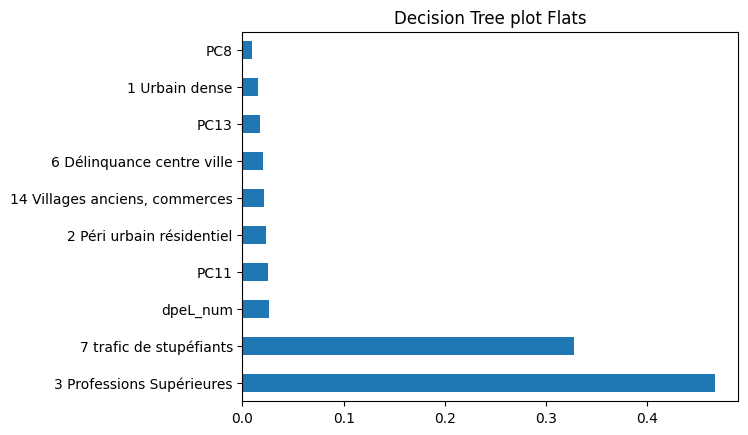

In [20]:
decision_tree = models["DecisionTreeRegressor"]
if DecisionTreeDisplay :
    feat_importances = pd.Series(
        decision_tree.feature_importances_, X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh',title="Decision Tree plot Flats")

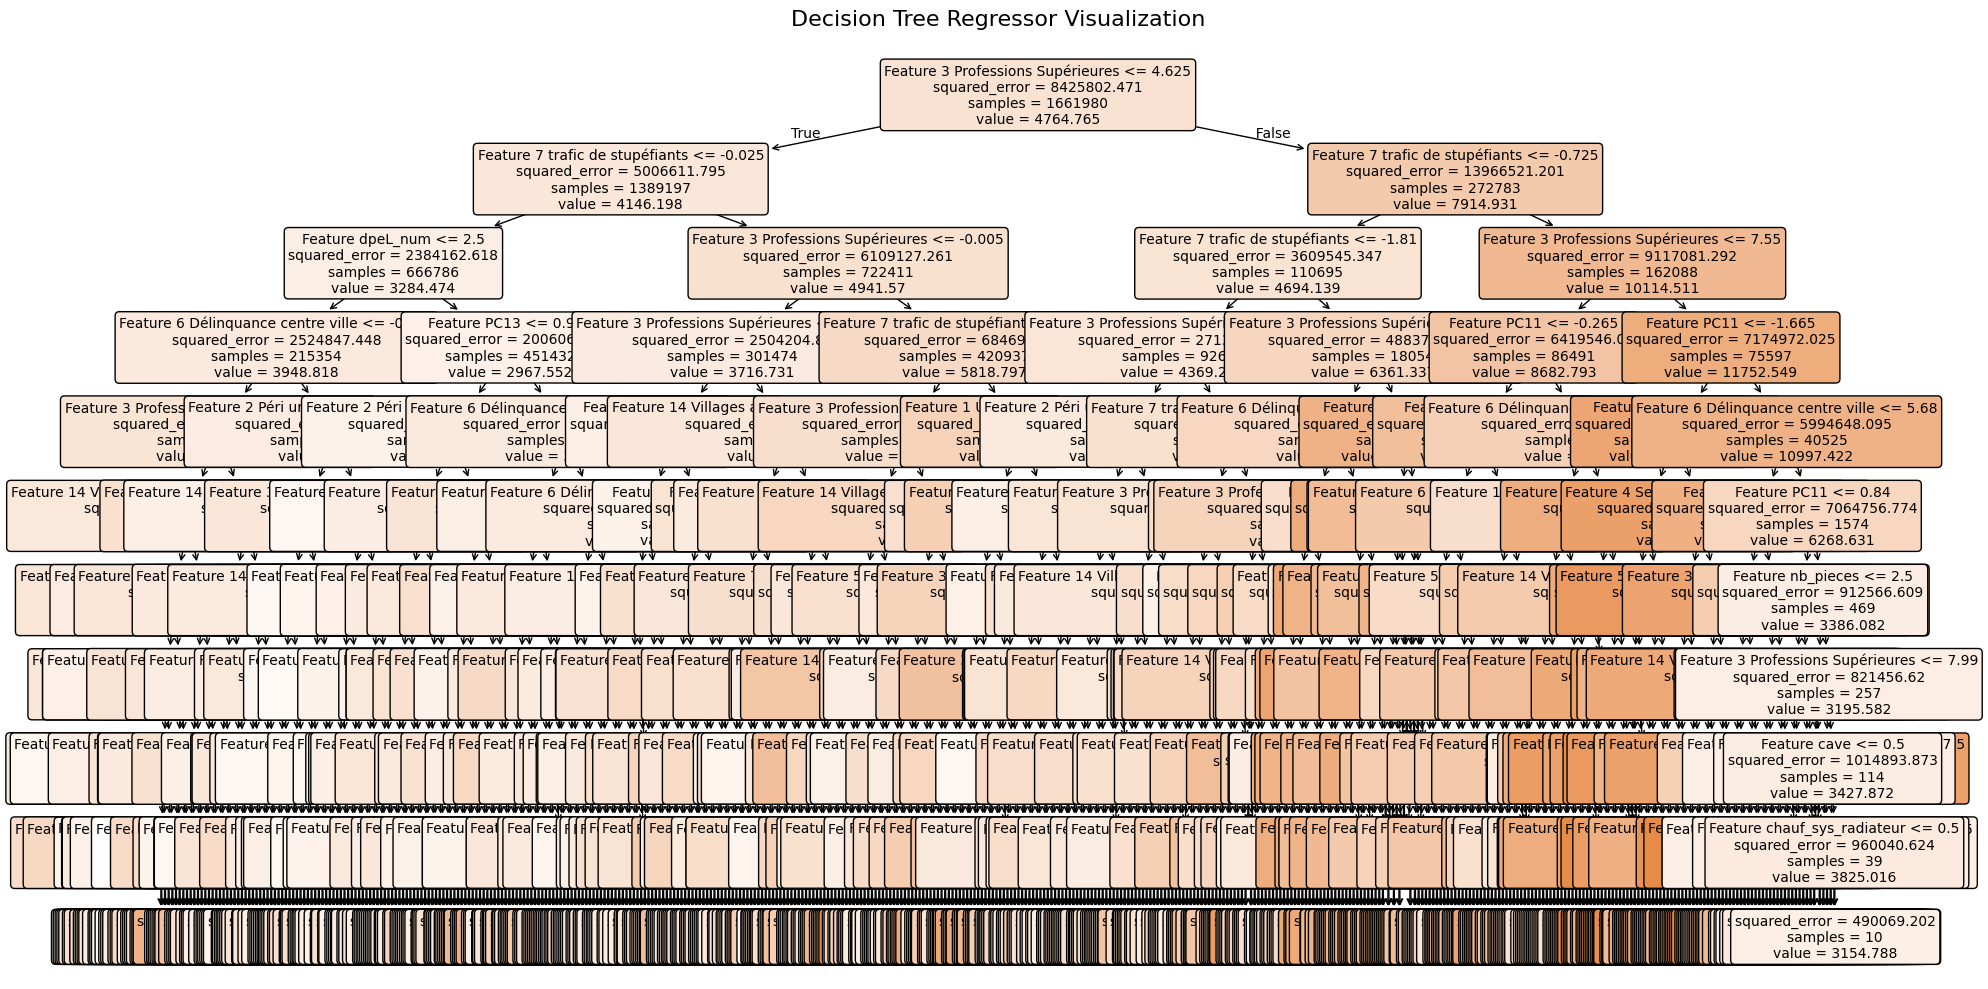

In [21]:
from sklearn.tree import plot_tree

if DecisionTreeDisplay :

    decision_tree = models["DecisionTreeRegressor"]
    # Visualize the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(decision_tree, 
            feature_names=[f'Feature {name}' for name in X.columns],
            filled=True,
            rounded=True,
            fontsize=10)

    plt.title("Decision Tree Regressor Visualization", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

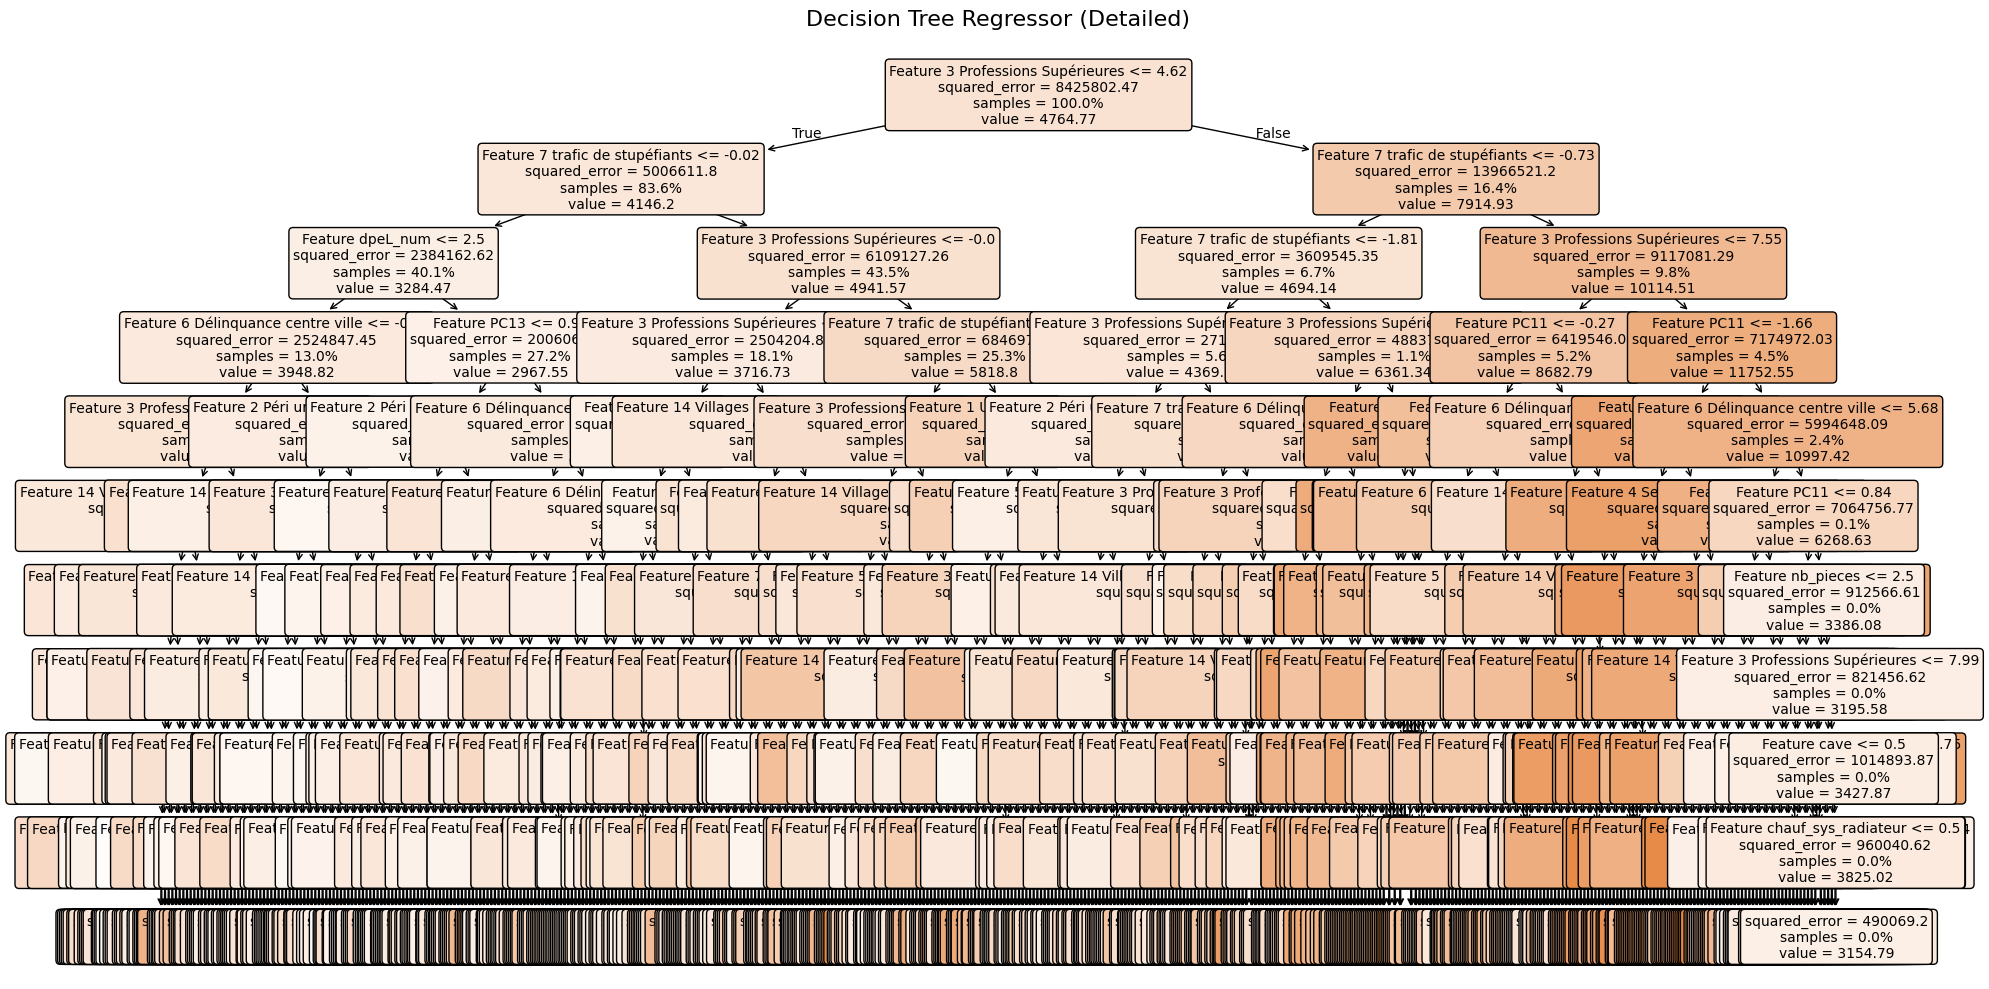

In [22]:
# Optional: More detailed visualization with additional parameters

if DecisionTreeDisplay :

    plt.figure(figsize=(20, 10))
    plot_tree(decision_tree, 
            feature_names=[f'Feature {name}' for name in X.columns],
            filled=True,
            rounded=True,
            fontsize=10,
            proportion=True,  # Show proportion of samples
            precision=2)      # Decimal precision

    plt.title("Decision Tree Regressor (Detailed)", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Shap interpretation of XGBRegressor

In [20]:
def interpret_results_with_shap (model_name, model,X_test) :

    print ("Shap for model ",model_name)

    y_pred = model.predict(X_test)
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)

    print("="*60)
    print("SHAP INTERPRETATION GUIDE")
    print("="*60)
    print("""
    SHAP values explain how each feature contributes to predictions:
    - Positive SHAP value → feature pushes prediction HIGHER
    - Negative SHAP value → feature pushes prediction LOWER
    - Magnitude → strength of the feature's impact

    Base value: average model prediction across training data
    Prediction = Base value + sum of SHAP values for all features
    """)

    return explainer, shap_values, y_pred

def shap_summary_plot (shap_values) :
    # ==============================================================================
    # 1. SUMMARY PLOT - Feature Importance Overview
    # ==============================================================================
    print("\n1. SUMMARY PLOT (Feature Importance)")
    print("-" * 60)
    print("Shows:")
    print("  • Which features are most important globally")
    print("  • Distribution of SHAP values for each feature")
    print("  • Color: feature value (red=high, blue=low)")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.tight_layout()
    plt.show()

def shap_bar_plot (shap_values) :
    # ==============================================================================
    # 2. BAR PLOT - Mean Absolute SHAP Values
    # ==============================================================================
    print("\n2. BAR PLOT (Mean Feature Importance)")
    print("-" * 60)
    print("Shows average impact magnitude of each feature")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.tight_layout()
    plt.show()

def shap_dependency_plot (shap_values,feature1,feature2,feature3) :
    # ==============================================================================
    # 3. DEPENDENCE PLOTS - Feature Effects
    # ==============================================================================
    print("\n3. DEPENDENCE PLOTS (Individual Feature Effects)")
    print("-" * 60)
    print("Shows how a feature's value affects predictions")
    print("Color shows interaction with another feature")

    # Plot for most important features
    important_features = [feature1, feature2, feature3]
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    for idx, feature in enumerate(important_features):
        plt.sca(axes[idx])
        shap.dependence_plot(feature, shap_values.values, X_test, 
                            show=False, ax=axes[idx])
    plt.tight_layout()
    plt.show()

def shap_waterfall_plot (shap_values, y_pred) :

    # ==============================================================================
    # 4. WATERFALL PLOT - Single Prediction Explanation
    # ==============================================================================
    print("\n4. WATERFALL PLOT (Single Prediction Breakdown)")
    print("-" * 60)
    print("Shows how features contribute to ONE specific prediction")
    print("Reading from bottom to top:")
    print("  • Starts at base value (average prediction)")
    print("  • Each bar shows a feature's contribution")
    print("  • Ends at the final prediction")

    sample_idx = 0
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_values[sample_idx], show=False)
    plt.tight_layout()
    plt.show()

    # Print numerical breakdown
    print(f"\nPrediction breakdown for sample {sample_idx}:")
    print(f"Base value: {shap_values[sample_idx].base_values:.4f}")
    for i, feature in enumerate(X_test.columns):
        print(f"{feature:12s}: {shap_values[sample_idx].values[i]:+.4f} "
            f"(feature value: {X_test.iloc[sample_idx][feature]:.4f})")
    print(f"{'Final pred':12s}: {y_pred[sample_idx]:.4f}")
    print(f"{'Actual':12s}: {y_test.iloc[sample_idx]:.4f}")


def shap_force_plot ( explainer, shap_values, X_test) :
    # ==============================================================================
    # 5. FORCE PLOT - Multiple Predictions
    # ==============================================================================
    print("\n5. FORCE PLOT (Visual Push/Pull of Features)")
    print("-" * 60)
    print("Red bars push prediction higher, blue bars push lower")

    shap.initjs()

    display(shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_test.iloc[0, :]))

    shap.force_plot(explainer.expected_value, shap_values.values[70,:], X_test.iloc[70,:])

def shap_feature_interactions_plot (explainer, feature2,feature3) :
    # ==============================================================================
    # 6. FEATURE INTERACTIONS
    # ==============================================================================
    print("\n6. INTERACTION VALUES (Advanced)")
    print("-" * 60)
    print("Identifies which features interact with each other")

    # Calculate interaction values (can be slow for large datasets)
    shap_interaction_values = explainer.shap_interaction_values(X_test.iloc[:100])

    # Plot interaction for top feature
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        (feature2, feature3),
        shap_interaction_values,
        X_test.iloc[:100],
        show=False
    )
    plt.title(f"Interaction between {feature2} and {feature3}")
    plt.tight_layout()
    plt.show()



In [21]:
# Create SHAP explainer
if ShapDisplay :

    model_name = "XGBRegressor"
    model = models[model_name]
    explainer, shap_values, y_pred = interpret_results_with_shap ("XGBRegressor", model,X_test)


Shap for model  XGBRegressor
SHAP INTERPRETATION GUIDE

    SHAP values explain how each feature contributes to predictions:
    - Positive SHAP value → feature pushes prediction HIGHER
    - Negative SHAP value → feature pushes prediction LOWER
    - Magnitude → strength of the feature's impact

    Base value: average model prediction across training data
    Prediction = Base value + sum of SHAP values for all features
    


In [ ]:
if AddACP :
    feature1 = "PC3"
    feature2 = "PC7"
    feature3 = "PC6"

    feature1 = ACPS[feature1]
    feature2 = ACPS[feature2]
    feature3 = ACPS[feature3]
else :
    feature1 = "charges_copro_m2"
    feature2 = "porte_digicode"
    feature3 = "nb_etages"

shap_summary_plot(shap_values)

shap_bar_plot(shap_values)

shap_dependency_plot(shap_values,feature1,feature2,feature3)

shap_waterfall_plot(shap_values,y_pred)

shap_force_plot(explainer,shap_values,X_test)

shap_feature_interactions_plot(explainer,feature2,feature3)




In [ ]:
feature1 ="dpeL_num"
feature2 = "ascenseur"
feature3 = "nb_pieces"
shap_dependency_plot(shap_values,feature1,feature2,feature3)

In [ ]:
# ==============================================================================
# 3. DEPENDENCE PLOTS - Feature Effects
# ==============================================================================
print("\n3. DEPENDENCE PLOTS (Individual Feature Effects)")
print("-" * 60)
print("Shows how a feature's value affects predictions")
print("Color shows interaction with another feature")

feature1 = "surface"
feature2 = "PC3"
feature3 = "PC7"
# Plot for most important features
important_features = [feature1, feature2, feature3]
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
for idx, feature in enumerate(important_features):
    plt.sca(axes[idx])
    shap.dependence_plot(feature, shap_values.values, X_test, 
                        show=False, ax=axes[idx])
plt.tight_layout()
plt.show()
